In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from ipywidgets import *

import itertools
from itertools import cycle

import torch
from torch import nn
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

from helpers.helpers import accuracy, plot_interpolated_faces, plot_resnet_pred

%load_ext autoreload
%autoreload 2

mpl.rc('figure', max_open_warning = 0)

%matplotlib inline

# Graded Exercise 2

**Date: 24.05.2022**


Welcome to the second graded exercise.

You are asked to fill in the code in a couple of cells throughout the exercise. The cells are independent of each other and you will receive points for each individual cell. We will not grant partial points within a cell.

The exercise has two parts. 
1. PCA (involving coding the PCA algorithm using NumPy)
2. CNN (involving coding a Residual CNN using PyTorch)

Feel free to start with whichever part you find more comfortable.

Before you finish, please make sure to **upload your jupyter notebook graded_exercise_2.ipynb**. (We've made some changes to our grading framework and no longer require you to upload a separate answers file.)

Good luck! :)

### Important: Enter your SCIPER number below and run the cell

In [2]:
sciper_number = 330593  # e.g. 123456

## Part 1: PCA and Interpolation

The aim of this part is to practice applying PCA to face data and also explore the low-dimensional space even further. We will have three short exercises:

1. Implementing the Prinical Component Analysis (PCA) algorithm, 

2. Applying PCA on face data to get low-dimentional representations of the faces, then reconstruct the faces from their low-dimentional representations.

3. "Interpolate" between two different faces in the (projected) low-dimensional space. We will reconstruct the face from the low-dimensional interpolations and see how well it matches the interpolation in the image space.

Let's begin!


### 1.1. Introducing the dataset

We are using a face image dataset called the Olivetti faces dataset, which should be familiar to you. The dataset contains 400 face images and each face is a 64*64(=4096) grayscale image.

A visualization of the first image in the dataset is given below.

Let's call the 0th-face Alice and the 1st-face Bob.

Dimensions of the Face dataset: N=400, D=4096


Text(0.5, 1.0, 'Face 0: Alice')

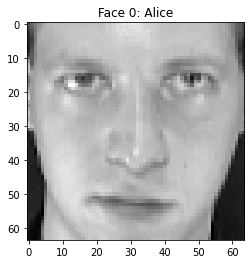

In [3]:
faces = np.load("helpers/datasets/olivetti_faces.npy")
print(f'Dimensions of the Face dataset: N={faces.shape[0]}, D={faces.shape[1]}')

# Show the first face
plt.figure()
plt.imshow(faces[2].reshape(64,64), cmap='gray')
plt.title('Face 0: Alice')

### 1.2 Introducing PCA

Data samples $\mathbf{x}_i \in \mathbb{R}^{D},\, i=0,...N-1$ are stored as row-vectors in the full data array $\mathbf{X} \in \mathbb{R}^{N\times D}$.

Let's remind ourselves how we do PCA to project the data to $d<D$ dimensions:
1. Center the data by subtracting the mean.
2. Find the covariance matrix using the centered data.
3. Compute the eigenvectors of the covariance matrix (hint: you may use `np.linalg.eigh`).
4. Choose the eigenvectors corresponding to the largest $d$ eigenvalues in **descending** order. (hint: the eigenvalues returned by `np.linalg.eigh` are in ascending order. The eigenvector matrix returned by this function places the eigenvectors in the *columns*, not the rows!) 
5. These eigenvectors are called the principal components, and we will return them in a `np.array` of shape (D,d).
6. **Output:** we ask you to return the following:
    1. the mean of the data `X_mean`
    2. an array `W` of the first $d$ principal components (PC)
    3. additionally, return the *most* influential PC (:= corresponding to the largest eigenvalue) `most_influential_pc` of shape (d,)
    4. and the *least* influential PC (:=corresponding to the lowest eigenvalue) `least_influential_pc` of shape (d,)

Please fill in the `PCA` function given below:

In [4]:
def PCA(X, d):
    
    '''
    Function implementing the PCA operation.
    
    Input:
        X (np.array): Data to be projected, shape (N, D)
        d (int): Number of principal components to be used to reduce dimensionality

    Output:
        X_mean (np.array): The mean of the input data, shape (D,)
        W (np.array): The principal components, shape (D,d)
        most_influential_pc (np.array) : The principal component which has the most influence on the explained variance,
                                shape (D,)
        least_influential_pc (np.array) : The principal component which has the least influence on the explained variance,
                                shape (d,)
    '''
    
    # WRITE YOUR CODE HERE
    
    # Compute the mean of data
    X_mean = np.mean(X, 0)

    # Center the data with the mean
    X_tilde = X - X_mean
    
    # Create the covariance matrix
    C = X_tilde.T@X_tilde/X_tilde.shape[0]
    
    # Compute the eigenvectors and eigenvalues. Hint: use np.linalg.eigh
    eigvals, eigvecs = np.linalg.eigh(C)
    
    # Choose the top d eigenvalues and corresponding eigenvectors. Sort the eigenvalues( with corresponding eigenvectors )
    # in decreasing order first.
    eigvals = eigvals[::-1]
    eigvecs = eigvecs[:, ::-1]
    

    W = eigvecs[:, 0:d]
    most_influential_pc = eigvals[0:d]
    

    # project the data using W
    Y = X_tilde@W
    
    # Compute the explained variance. Note: we want it in percentage
    least_influential_pc = 100*most_influential_pc.sum()/eigvals.sum()
    
    

    return X_mean, W, most_influential_pc, least_influential_pc

In [5]:
d = 30
X_mean, W, most_influential_pc, least_influential_pc = PCA(faces, d)

### 1.3 Projection to a lower dimensional representation

We have now found the principal components, which we can use to reduce the dimensionality of the faces dataset. 

We can now project one original data sample $\mathbf{x}_i \in \mathbb{R}^{D}$ to a lower-dimensional representation $\mathbf{y}_i  \in \mathbb{R}^{d} $ using the principal component matrix. Please fill in the function `face_project` that performs this operation.



In [6]:
def face_project(single_face, W, X_mean):
    '''
    Input:
        single_face (np.array): Single face that will be reconstructed, shape (D,)
        W (np.array): The principal components found via PCA, shape (D,d)
        X_mean (np.array): Mean of the input data, shape (D,)

    Output:
        lowdim_repr (np.array): The low-dimensional representation of the face (i.e. projected face), shape (d,)
    '''
    # WRITE YOUR CODE HERE
    lowdim_repr = W.T@(single_face-X_mean)
    return lowdim_repr

Now we project the face for Alice (Face 0) and Bob (Face 1). Run the cell below to output their low-dimensional representations.

In [7]:
face_0 = faces[0, :]
face_1 = faces[1, :]

lowdim_repr_0 = face_project(face_0, W, X_mean)
lowdim_repr_1 = face_project(face_1, W, X_mean)

### 1.4. Reconstruction from a lower dimensional representation

From this compressed representation $\mathbf{y}_i$, we can recover an approximation of the original data, again using the principal component matrix.

Please fill in the function `face_reconstruct` that performs this operation.

In [8]:
def face_reconstruct(lowdim_repr, W, X_mean):

    '''
    Input:
        lowdim_repr (np.array): The low-dimensional representation of the face (i.e. projected face), shape (d,)
        W (np.array): The principal components found via PCA, shape (D,d)
        X_mean (np.array): Mean of the input data, shape (D,)

    Output:
        reconstructed_face (np.array): A single reconstructed face, shape (D,)
    '''
    # WRITE YOUR CODE HERE
    reconstructed_face = X_mean + W@lowdim_repr
    return  reconstructed_face

Text(0.5, 1.0, 'Face 1, Reconstructed: Bob')

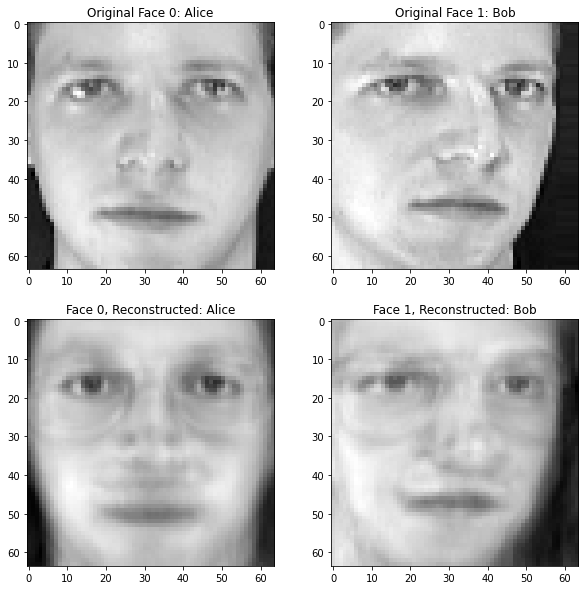

In [9]:
reconstructed_face_0 = face_reconstruct(lowdim_repr_0, W, X_mean)
reconstructed_face_1 = face_reconstruct(lowdim_repr_1, W, X_mean)

# Visualization
plt.figure(figsize=(10,10))
ax = plt.subplot(2,2,1)
plt.imshow(face_0.reshape(64,64),cmap='gray')
ax.set_title('Original Face 0: Alice')
ax = plt.subplot(2,2,2)
plt.imshow(face_1.reshape(64,64),cmap='gray')
ax.set_title('Original Face 1: Bob')
ax = plt.subplot(2,2,3)
plt.imshow(reconstructed_face_0.reshape(64,64),cmap='gray')
ax.set_title('Face 0, Reconstructed: Alice')
ax = plt.subplot(2,2,4)
plt.imshow(reconstructed_face_1.reshape(64,64),cmap='gray')
ax.set_title('Face 1, Reconstructed: Bob')

### 1.5 Interpolation of Faces

Given two vectors $\mathbf{x}_1 , \mathbf{x}_2$, and a scalar $0 \le \alpha \le 1$, the output of the interpolation between $\mathbf{x}_1, \mathbf{x}_2$, called interpolant, is defined as

$$\mathbf{x} = \alpha \mathbf{x}_1 + (1-\alpha) \mathbf{x}_2.$$

Informally, the output of the interpolation can be seen as a mixture of the inputs.

Implement the `interpolation` function between two vectors.

In [10]:
def interpolation(x1, x2, alpha):
    '''
    Input:
        x1 (np.array): the input array 1
        x2 (np.array): the input array 2
        alpha (float):  the interpolation coefficent (of x1)

    Output:
        x (np.array): the interpolant mentioned above
    '''
    
    # WRITE YOUR CODE HERE
    return alpha*x1 + (1-alpha)*x2

With the notion of interpolation, we now interpolate between two face images in the context of PCA. There are two ways of interpolation:

1. Directly interpolating in the image space $\mathbb R^D$ from two original faces;

2. Interpolating in the low-dimentional (projected) representation space $\mathbb R^d$, then reconstructing the face from the interpolated low-dimentional representation.

Now let's interpolate between Alice (Face 0) and Bob (Face 1), using the two ways of interpolation with coefficients (0.25, 0.5, 0.75). 

First let's interpolate in image space and visualize the results.

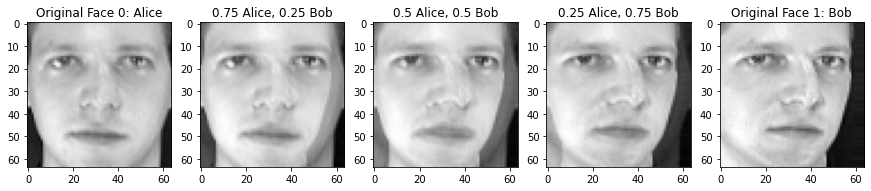

In [11]:
interpolation_in_image_space_25 = interpolation(face_0, face_1, 0.25)
interpolation_in_image_space_50 = interpolation(face_0, face_1, 0.50)
interpolation_in_image_space_75 = interpolation(face_0, face_1, 0.75)

# Visualization
plot_interpolated_faces(face_0, interpolation_in_image_space_75,interpolation_in_image_space_50,
                        interpolation_in_image_space_25, face_1)


Now let's interpolate in the low dimensional space and reconstruct the faces from the interpolations. We visualize these results as well. Which interpolation looks more natural to you (this is not an exam question, just for you to think about! :) )

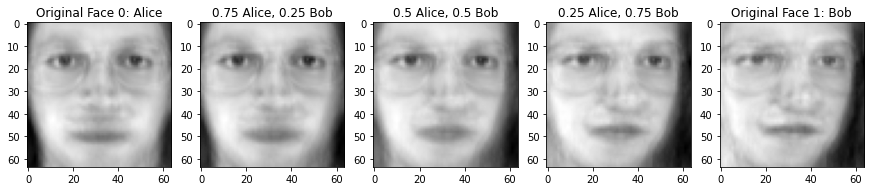

In [12]:
interpolation_in_low_dim_25 = face_reconstruct(interpolation(lowdim_repr_0, lowdim_repr_1, 0.25), W, X_mean)
interpolation_in_low_dim_50 = face_reconstruct(interpolation(lowdim_repr_0, lowdim_repr_1, 0.5), W, X_mean)
interpolation_in_low_dim_75 = face_reconstruct(interpolation(lowdim_repr_0, lowdim_repr_1, 0.75), W, X_mean)

# Visualization
plot_interpolated_faces(reconstructed_face_0, interpolation_in_low_dim_75,interpolation_in_low_dim_50,
                        interpolation_in_low_dim_25, reconstructed_face_1)



## Part 2: Residual CNN

Neural networks can be seen as a succession of transformations $\mathcal{H}(\cdot)$ applied to the input $\mathbf{x}$:
$$\mathrm{NN}\left( \mathbf{x} \right) = \mathcal{H}_L\circ\mathcal{H}_{L-1} \circ\dots\circ \mathcal{H}_0\left( \mathbf{x} \right).$$

Traditionally, the layers are trained to directly learn the mapping $\mathcal{H}(\cdot)$. For example, a linear layer with a sigmoid activation function $\sigma(\cdot)$ would compute it as
$ \mathcal{H}(\mathbf{x}) = \sigma\left(W^\top \mathbf{x} + \mathbf{b} \right).$

Instead, residual networks aim to learn a *residual* mapping, that is they are trained to learn a transformation $\mathcal{F}(\cdot)$ so that the result can be computed as

$$\mathcal{H}(\mathbf{x}) = \mathcal{F}(\mathbf{x}) + \mathbf{x}.$$

Taking again the example of a single linear layer, the overall mapping $\mathcal{H}(\cdot)$ would then become
$ \mathcal{H}(\mathbf{x}) = \sigma\left(W^\top \mathbf{x} + \mathbf{b} \right) + \mathbf{x}.$


A ResNet network is composed of a sequence of similar blocks, called ResBlocks. On the image below, you can see the structure of a single ResBlock for a linear layer.

<img src="helpers/img/reslinear.png" width=500></img>

The addition of $\mathbf{x}$ to the computed residual can be seen as a sort of "skip connection" from the input to the output.

When residual networks, or ResNets, were proposed [1], the authors hypothesized that the residual mapping $\mathcal{F}(\cdot)$ might be easier to learn than the full mapping $\mathcal{H}(\cdot)$.
Importantly, it also allowed to build much deeper network as the gradient could now back-propagate through these skip connections without vanishing.

In this part of the graded exercise, we ask you to use PyTorch to write a residual CNN by first implementing a residual convolutional block and then using that block to build the network. We will then train it to classify images of written digits.

**Practical note:** avoid using the variable name `F` as it is already used as an alias to import `torch.nn.functional`.

---

[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Jian Sun. Deep residual learning for image recognition. *In IEEE Conference on Computer Vision and Pattern Recognition (CVPR)*, 2016.

### 2.1 Introducing the data

In this exercise, we will work with probably one of the most popular datasets in machine learning and computer vision in particular -- MNIST. This dataset consists of thousands of pictures of digits. This way, we have 10 classes ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]) assigned to each image in the dataset. For the sake of time, we will train our model only on a part of the whole dataset (1000 images). In what follows, you will build a neural model that would be able to automatically indicate which digit an image contain.

In [13]:
in_channels = 1 # number of channels in input image
n_classes = 10 # total number of classes

In [14]:
dataset_train = torchvision.datasets.MNIST("./", download=True, train=True, transform=transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST("./", download=True, train=False, transform=transforms.ToTensor())

dataset_train = Subset(dataset_train, range(1000))
dataset_test = Subset(dataset_test, range(1000))

dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)
dataloader_test = DataLoader(dataset_train, batch_size=64, shuffle=False)

To have a better impression of what we're working with, lets plots some random samples from our data:

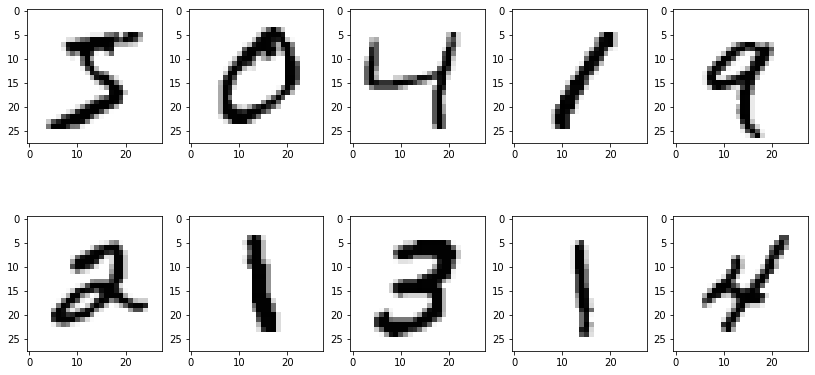

In [15]:
fig = plt.figure(figsize=(14, 7))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(dataset_train[i][0][0], cmap="gray_r")

### 2.2. Residual Block

Our ResNet model will be built with double convolutions with the addition of a skip connection. Therefore, we start by implementing this operation.
The structure of these blocks is taken from [1] and is depicted in the figure below:

<img src="helpers/img/resconv.png"></img>

(If the image is not displayed, you can find it as in the `img` folder as `resconv.png`)

They consist of two $3\times3$-convolutional layers with $\mathrm{ReLU}$ activations, and a skip connection. Moreover, they chose to apply the second activation *after* the addition and use batch normalization after each convolution.

You are asked to fill the `forward` pass of the `ResBlock` module below. We have already provided the `__init__` function.

**Note:** we need the output of the convolution operations to be of same size as the input image in order to sum them. Therefore:
* The output feature maps should have the same size as the input ones, so we use padding for the convolutions.
* The number of channels remains unchanged through the convolutions. (The 2D convolutions will take the images from n_channels to n_channels.)

In [16]:
class ResBlock(nn.Module):
    """
    Residual convolutional block.
    
    The residual mapping F(x) consists of: 
    convolution => batch-normalization => ReLU => convolution => batch-normalization.
    Then the final output H(x) is :
    relu(F(x) + x)
    """
    
    def __init__(self, n_channels):
        '''
        n_channels (int): The number of channels the convolution operations use for both input and output.
        '''
        
        # The following line initialize the parent class, you can safely ignore it.
        super().__init__()

        
        self.G = nn.Sequential(
            nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(n_channels, n_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_channels)
        )
        # In the forward pass you can use F.relu for the ReLU function.

    def forward(self, x):
        '''
        x (torch.FloatTensor): The input image
        '''
        ## we need to keep the unchanged input to sum with before applying the final ReLU
        x_input = x.clone()

        
        ## YOUR CODE HERE
        x_out = F.relu(self.G(x_input) + x) 
        
        
        
        return x_out

You can use the following cell to try out your module. Do the output shapes look reasonable?

In [17]:
channels = 16

res_block = ResBlock(channels)
res_x = torch.rand(4, channels, 28, 28)
res_y = res_block(res_x)
print(f"Input shape  = {res_x.shape}")
print(f"Output shape = {res_y.shape}")

Input shape  = torch.Size([4, 16, 28, 28])
Output shape = torch.Size([4, 16, 28, 28])


### 2.3. Implementing a Residual Network
Now that we have implemented residual convolutional blocks, let's use them to write our own residual network.

The architecture of the model we want to define is shown in the figure below.

<img src="helpers/img/resnet.png" width=800></img>

As you can see, we first use a convolution to increase the number of channels, then two `ResBlock`s, and finally a max-pooling of size $2$. This is done twice before the features are flattened into a vector and sent through two linear layers to get the output.

Below, we have provided you with the `forward` function of the model, and we ask you to fill the `__init__` function of this `ResNet`.

**Note:**
* The convolutions will again need padding to avoid reducing the feature maps size.
* The max-poolings must reduce the feature maps size by $2$, therefore their kernel size must be $2$.

**/!\ Helper:** 
* We have provided you with `DummyBlock`, a replacement that simply computes the identity function $\mathcal{H}\left(\mathbf{x}\right) = \mathbf{x}$. You can use it instead of your `ResBlock` if you were not able to implement it or if you wish to verify that your `ResNet` implementation is correct independently of exercise **1.2**.
* `DummyBlock` will verify if the number of channels it was given is correct during the forward pass.
* When grading your exercise, using either `DummyBlock` or `ResBlock` will be considered correct. (Make sure you use either **only** `DummyBlock` **or** `ResBlock`, do not mix them!)

In [18]:
class DummyBlock(nn.Module):
    """
    Dummy block, simply computes the identity function H(x) = x.
    
    You may use it instead of your ResBlock in the model, but do not forget
    to give it the correct number of channels at that point in the model!
    """
    
    def __init__(self, n_channels):
        # The following line initialize the parent class, you can safely ignore it.
        super().__init__()
        
        self.n_channels = n_channels

    def forward(self, x):
        
        # We verify if the memorized number of channels is correct
        assert x.shape[1] == self.n_channels, f"{x.shape[1]} != {self.n_channels}"
        
        # We return a copy of x to implement the identity function
        return x.clone()

In [19]:
class ResNet(nn.Module):
    """Residual network."""
    
    def __init__(self, in_channels, n_classes):
        '''
        in_channels (int): The number of channels the the first convolution operation takes as input.
        n_classes (int): The total number of classes we use for the output of the final linear layer.
        '''
            
        # The following line initialize the parent class, you can safely ignore it.
        super().__init__()
        
        # YOUR CODE HERE
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.rb1 = res_block = DummyBlock(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.rb2 = res_block = DummyBlock(64)
        self.fc1 = nn.Linear(64*7*7, 256)
        self.fc2 = nn.Linear(256, 10)


    def forward(self, x):
        # YOUR CODE HERE
        x = F.max_pool2d(self.rb1.forward(self.rb1.forward(F.relu(self.conv1(x)))), 2)
        x = F.max_pool2d(self.rb2.forward(self.rb2.forward(F.relu(self.conv2(x)))), 2)
        x = x.reshape((x.shape[0], -1))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

You can use the following cell to try out your model.

In [20]:
resnet = ResNet(in_channels, n_classes)
input_x = next(iter(dataloader_train))[0]
res_y = resnet(input_x)
print(f"Input shape  = {input_x.shape}")
print(f"Output shape = {res_y.shape}")

Input shape  = torch.Size([64, 1, 28, 28])
Output shape = torch.Size([64, 10])


### 2.4 Training
Now that we have defined our residual model, we can train it on our data.

You are tasked with implementing `get_criterion_and_optimizer`, a simple function that must return the criterion (:= the function computing the loss), and the optimizer that will apply gradient descent to the parameters of our network.

* For the criterion, we want to use the Cross-Entropy that you have already encountered in the exercises.
* For the optimizer, we will use Adam.

Then, we provide you with the function `train_model` to train your `ResNet` over the dataset.

**Note:**
* if the training is very slow on your machine, you can try to replace `ResBlock` by `DummyBlock` in your model. That should significantly speed up the training, and you should still get a high test accuracy.

In [21]:
def get_criterion_and_optimizer(model, lr):
    '''
    Input: 
        model (torch.nn.Module): The model used for training.
        lr (float): The learning rate
    Return:
        critereon (torch.nn.modules.loss.CrossEntropyLoss): Cross entropy loss object
        optimizer (torch.optim.Adam): Adam optimizer object, intiialized with the learning rate set to lr.
    '''
    # YOUR CODE HERE
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return criterion, optimizer

In [22]:
# The following functions are already implemented, no need to write code

def train_model(model, lr, dataloader_train, dataloader_test, n_epochs):
    criterion, optimizer = get_criterion_and_optimizer(model, lr=lr)
    
    for epoch in range(n_epochs):
        # Training.
        model.train()
        for it, (x, y) in enumerate(dataloader_train):
            # Forward pass: compute predictions
            preds = model(x)
            
            # Compute the loss of the predictions
            loss = criterion(preds, y)
            
            # Backward pass: compute the gradient and
            # perform a step of gradient descent
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            print('\rEp {}/{}, it {}/{}: loss train: {:.2f}, accuracy train: {:.2f}'.
                  format(epoch + 1, n_epochs, it + 1, len(dataloader_train), loss,
                         accuracy(preds, y)), end='')

        # Testing.
        model.eval()
        with torch.no_grad():
            acc_run = 0
            for x, y in dataloader_test:
                acc_run += accuracy(model(x), y) * x.shape[0]
            acc = acc_run / len(dataloader_test.dataset)
            print(', accuracy test: {:.2f}'.format(acc))
            
def predict(model, test_input):
    pred_output = model(test_input)
    pred_label = pred_output.argmax(dim=1)
    return pred_label

In [23]:
lr = 0.001
n_epochs = 3

model = ResNet(in_channels, n_classes)
train_model(model, lr, dataloader_train, dataloader_test, n_epochs)

Ep 1/3, it 16/16: loss train: 1.20, accuracy train: 0.78, accuracy test: 0.74
Ep 2/3, it 16/16: loss train: 0.70, accuracy train: 0.78, accuracy test: 0.77
Ep 3/3, it 16/16: loss train: 0.29, accuracy train: 0.85, accuracy test: 0.89


  And run the following cell to test your model:

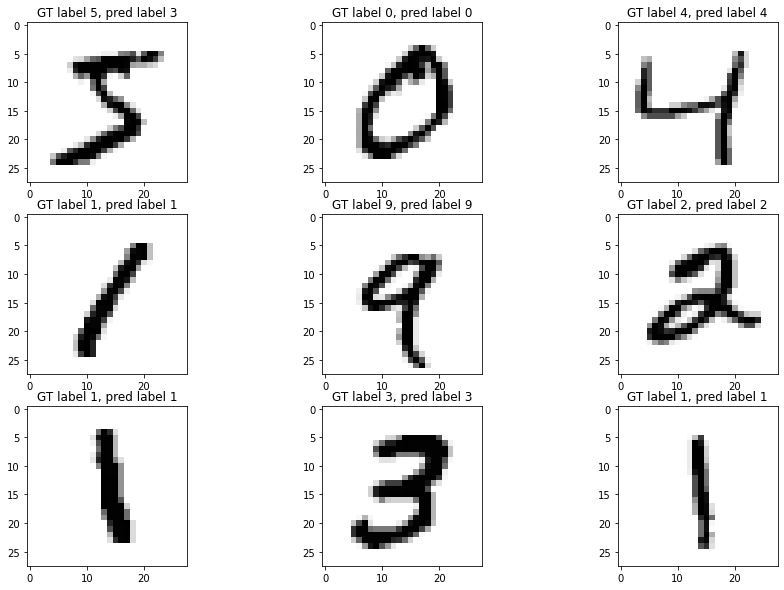

In [24]:
(input_x, gt_labels) = next(iter(dataloader_test))
pred_labels = predict(model, input_x)
plot_resnet_pred(input_x, gt_labels, pred_labels)

And you're done! Be sure to submit your notebook on Moodle for grading! 